# Removing scattered light from *TESS* light curves using linear regression (`RegressionCorrector`)

## Learning Goals

By the end of this tutorial, you will:
 - Be familiar with the Lightkurve `RegressionCorrector`.
 - Understand how to create regressors from a `TargetPixelFile` object.
 - Be able to remove the scattered light background signal from *TESS* data.

## Introduction

Lightkurve offers several tools to the community for removing instrument noise and systematics from data from the *Kepler*, *K2*, and *TESS* missions. This tutorial will demonstrate the use of Lightkurve's `RegressionCorrector` class to remove the scattered light and spacecraft motion noise from *TESS* Full Frame Images (FFIs).

*TESS* FFIs have an additive scattered light background that has not been removed by the pipeline. This scattered light must be removed by the user. This can be done in a few ways, including a basic median subtraction. In this tutorial, we'll show you how to use Lightkurve's corrector tools to remove the scattered light. 

## Imports

This tutorial requires the [**Lightkurve**](http://docs.lightkurve.org/) package, and also makes use of **[NumPy](https://numpy.org/)** and **[Matplotlib](https://matplotlib.org/)**.

In [1]:
import lightkurve as lk
from lightkurve.correctors import RegressionCorrector, DesignMatrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

## 1. Using `RegressionCorrector` on TESSCut FFI Cutouts

For this tutorial we will use the *TESS* Sector 15 data of [KIC 8462852](https://en.wikipedia.org/wiki/Tabby%27s_Star) (also known as Boyajian's Star).
We'll start by downloading the FFI data using MAST's TESSCut service, querying it through Lightkurve.

In [2]:
target = "KIC 8462852"  # Boyajian's Star
tpf = lk.search_tesscut(target, sector=15).download(cutout_size=(50, 50))

In [3]:
tpf

TessTargetPixelFile(TICID: KIC 8462852)

This cutout works the same as any Lightkurve target pixel file (TPF). *TESS* FFI cutouts do not have aperture masks created by the pipeline. Instead, users must create their own apertures. There are many methods we could use to do this, but for now we can create a threshold aperture, using Lightkurve's `create_threshold_mask()` method.

In [4]:
aper = tpf.create_threshold_mask()

Let's plot the aperture to make sure it selected the star in the center and has a reasonable number of pixels.

<AxesSubplot:title={'center':'Target ID: KIC 8462852, Cadence: 0'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

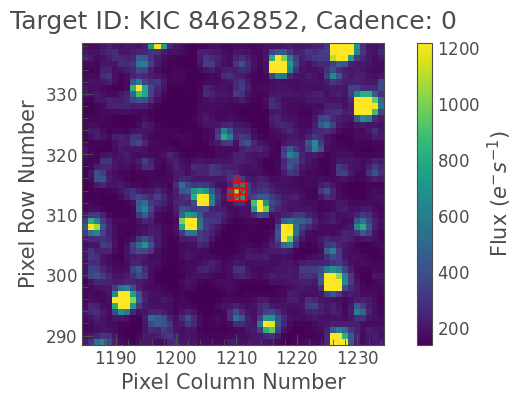

In [5]:
tpf.plot(aperture_mask=aper);

Looks good. We can sum up the pixels in this aperture, and create an uncorrected light curve.

In [6]:
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

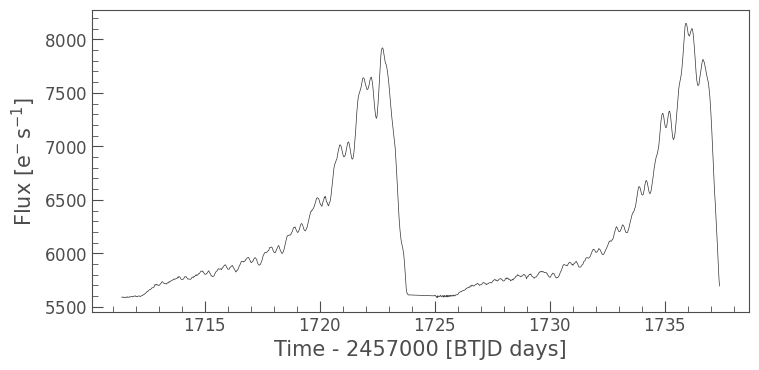

In [7]:
uncorrected_lc.plot();

## 2. Creating a `DesignMatrix` from Pixel Regressors

The flux in the aperture appears to be dominated by scattered light. We can tell because *TESS* orbits Earth twice in each sector, thus patterns which appear twice within a sector are typically related to the *TESS* orbit (such as the scattered light effect).

To remove this light, we are going to detrend the light curve against some vectors which we think are predictive of this systematic noise.

In this case, we can use the **pixels outside the aperture** as vectors that are highly predictive of the systematic noise, that is, we will make the assumption that these pixels do not contain any flux from our target.

We can select these pixels by specifying flux outside of the aperture using Python's bitwise invert operator `~` to take the inverse of the aperture mask.

In [8]:
regressors = tpf.flux[:, ~aper]

In [9]:
regressors.shape

(1190, 2491)

`regressors` is now an array with shape *ntime* x *npixels outside of the aperture*. If we plot the first 30 of these pixels, we can see that they contain mostly scattered light, with some offset terms.

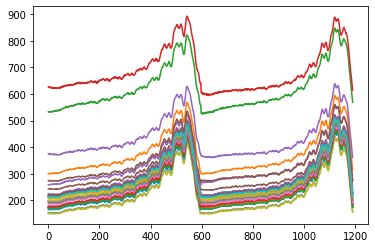

In [10]:
plt.plot(regressors[:, :30]);

In linear regression problems, it is common to refer to the matrix of regressors as the design matrix (also known as model matrix or regressor matrix). Lightkurve provides a convenient `DesignMatrix` class which is designed to help you work with detrending vectors. 

The `DesignMatrix` class has several convenience functions, and can be passed into Lightkurve's corrector objects. Please consult the [DesignMatrix page](https://docs.lightkurve.org/api/lightkurve.correctors.DesignMatrix.html) in the API docs for the full details on the methods and features provided by this class.

In [11]:
dm = DesignMatrix(regressors, name='regressors')

In [12]:
dm

regressors DesignMatrix (1190, 2491)

As shown above, `dm` is now a design matrix with the same shape as the input pixels. Currently, we have 2,541 pixels that we are using to detrend our light curve against. Rather than using all of the pixels, we can reduce these to their principal components using Principal Component Analysis (PCA). We do this for several reasons:

1. By reducing to a smaller number of vectors, we can remove some of the stochastic noise in our detrending vectors.
2. By reducing to the principal components, we can avoid pixels that have intrinsic variability (for example, from astrophysical long-period variables) that can be confused with the true astrophysical signal of our target.
3. By reducing the number of vectors, our detrending will be faster (although in this case, the detrending will still take seconds).

The choice of the number of components is a tricky issue, but in general you should choose a number that is much smaller than the number of vectors.

In [13]:
dm = dm.pca(5)

In [14]:
dm

regressors DesignMatrix (1190, 5)

Using the `pca()` method, we have now reduced the number of components in our design matrix to five. These vectors show a combination of scattered light and spacecraft motion, which makes them suited to detrend our input light curve.

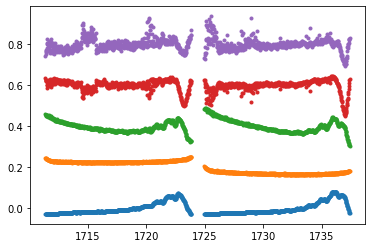

In [15]:
plt.plot(tpf.time.value, dm.values + np.arange(5)*0.2, '.');

Note: the `DesignMatrix` object provides a convenient `plot()` method to visualize the vectors:

<AxesSubplot:title={'center':'regressors'}, xlabel='Component', ylabel='X'>

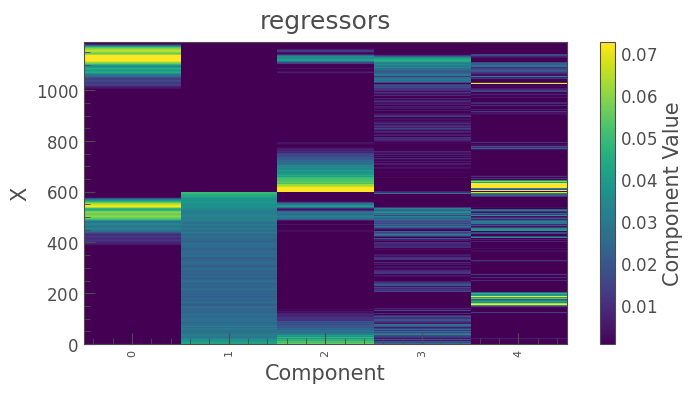

In [16]:
dm.plot();

We can now detrend the uncorrected light curve against these vectors. Lightkurve's `RegressionCorrector` will use linear algebra to find the combination of vectors that makes the input light curve **closest to zero**. To do this, we need one more component; we need an "offset" term, to be able to fit the mean level of the light curve. We can do this by appending a "constant" to our design matrix.

In [17]:
dm = dm.append_constant()

## 3. Removing Background Scattered Light Using Linear Regression

Now that we have a design matrix, we only need to pass it into a `lightkurve.Corrector`. To use our design matrix, we can pass it to the `RegressionCorrector`, which will detrend the input light curve against the vectors we've built.

Please consult the [RegressionCorrector page](https://docs.lightkurve.org/api/lightkurve.correctors.RegressionCorrector.html) in the API docs for the full details on the methods and features provided by this class.

In [18]:
corrector = RegressionCorrector(uncorrected_lc)

In [19]:
corrector

RegressionCorrector (ID: KIC 8462852)

To correct the light curve, we pass in our design matrix.

In [20]:
corrected_lc = corrector.correct(dm)

Now we can plot the results:

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

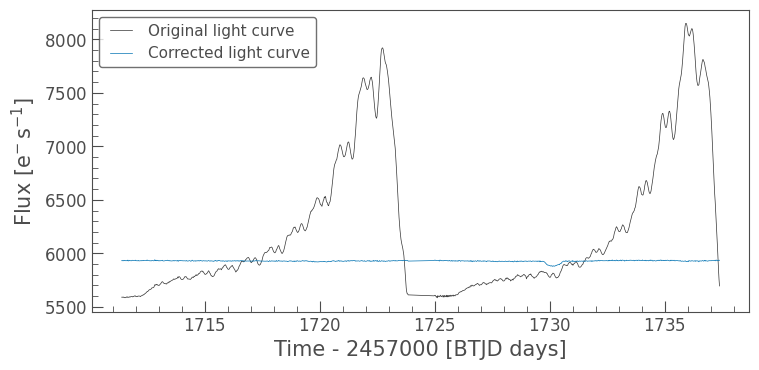

In [21]:
ax = uncorrected_lc.plot(label='Original light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

As shown above, the scattered light from the background has been removed. If we want to take a more in-depth look at the correction, we can use the `diagnose()` method to see what the `RegressionCorrector` found as the best fitting solution.

## 4. Diagnosing the Correction

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

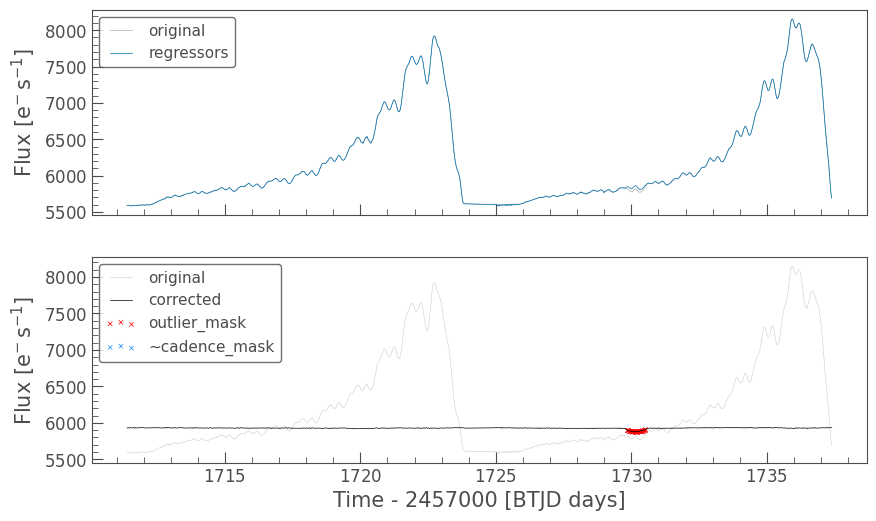

In [22]:
corrector.diagnose();

The `RegressionCorrector` has clipped out some outliers during the fit of the trend. You can read more about the outlier removal, how to pass a cadence mask, and error propagation in the [docs](https://docs.lightkurve.org/api/lightkurve.correctors.RegressionCorrector.html#lightkurve.correctors.RegressionCorrector).

**Watch Out!**

The `RegressionCorrector` assumes that you want to remove the trend and set the light curve to the **mean** level of the **uncorrected light curve**. This isn't true for *TESS* scattered light. *TESS* FFI light curves have **additive background**, and so we want to reduce the flux to the lowest recorded level, assuming that at that point the contribution from scattered light is approximately zero.

To do this, we will first need to look at the model of the background that `RegressionCorrector` built. We can access that in the `corrector` object.

In [23]:
corrector.model_lc

time,flux,flux_err
,electron / s,electron / s
object,float64,float64
1711.3882446289062,-341.1881606892721,0.0
1711.4090576171875,-341.2140788644083,0.0
1711.4298706054688,-341.9634439702777,0.0
1711.4507446289062,-341.83822804041574,0.0
1711.4715576171875,-342.1986575923329,0.0
1711.4923706054688,-342.1091946303832,0.0
1711.5132446289062,-345.879903116238,0.0
1711.5340576171875,-347.95382323867307,0.0


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

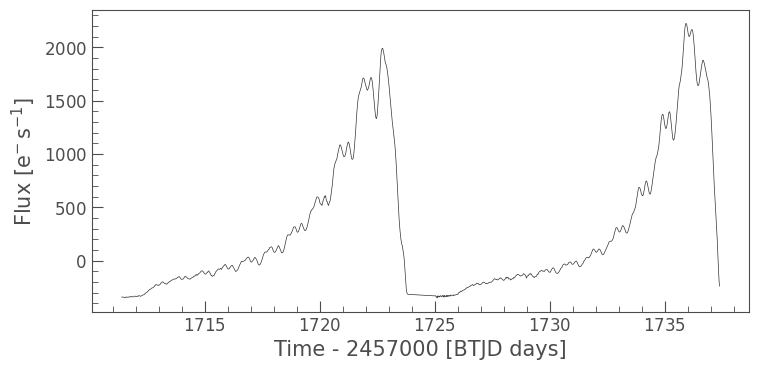

In [24]:
model = corrector.model_lc
model.plot();

As you can see above, the model drops below zero flux. This is impossible; the scattered light can't be removing flux from our target! 

To rectify this, we can subtract the model flux value at the 5th percentile.

In [25]:
# Normalize to the 5th percentile of model flux
model -= np.percentile(model.flux, 5)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

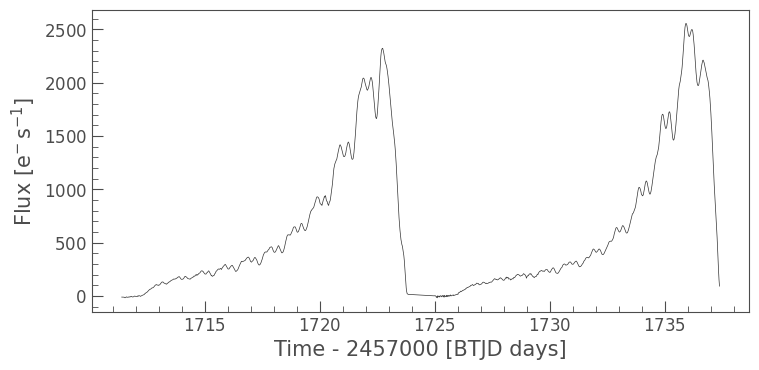

In [26]:
model.plot();

This looks better. Now we can remove this model from our uncorrected light curve.

In [27]:
corrected_lc = uncorrected_lc - model

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

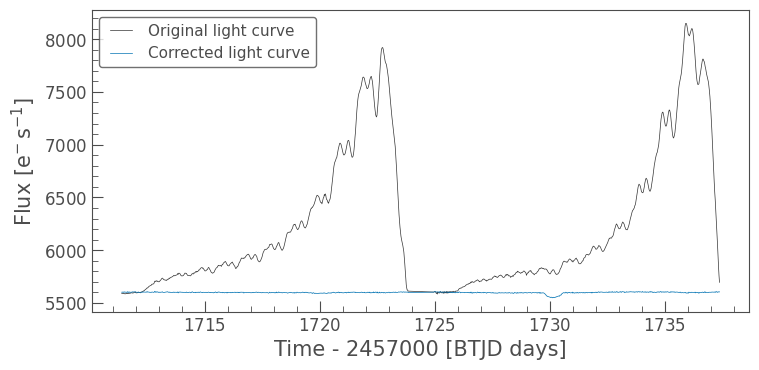

In [28]:
ax = uncorrected_lc.plot(label='Original light curve')
corrected_lc.plot(ax=ax, label='Corrected light curve');

This looks great. As a final test, let's investigate how the light curve we obtained using `RegressionCorrector` compares against a light curve obtained using a more basic median background removal method.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

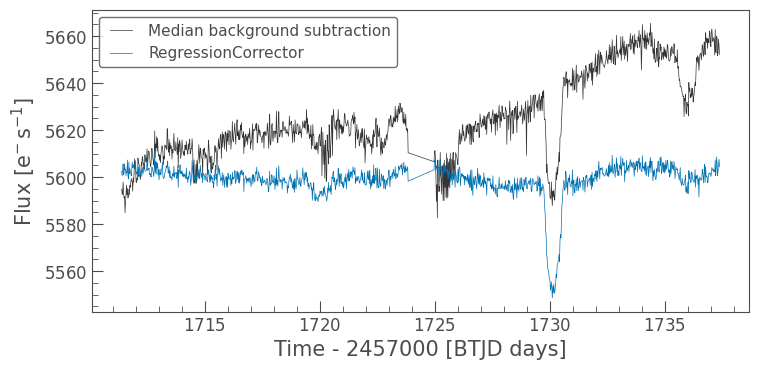

In [29]:
bkg = np.median(regressors, axis=1)
bkg -= np.percentile(bkg, 5)

npix = aper.sum()
median_subtracted_lc = uncorrected_lc - npix * bkg

ax = median_subtracted_lc.plot(label='Median background subtraction')
corrected_lc.plot(ax=ax, label='RegressionCorrector');

Lastly, let's show how you can do all of the above in a single cell.

In [30]:
# Make an aperture mask and an uncorrected light curve
aper = tpf.create_threshold_mask()
uncorrected_lc = tpf.to_lightcurve(aperture_mask=aper)

# Make a design matrix and pass it to a linear regression corrector
dm = DesignMatrix(tpf.flux[:, ~aper], name='regressors').pca(5).append_constant()
rc = RegressionCorrector(uncorrected_lc)
corrected_ffi_lc = rc.correct(dm)

# Optional: Remove the scattered light, allowing for the large offset from scattered light
corrected_ffi_lc = uncorrected_lc - rc.model_lc + np.percentile(rc.model_lc.flux, 5)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

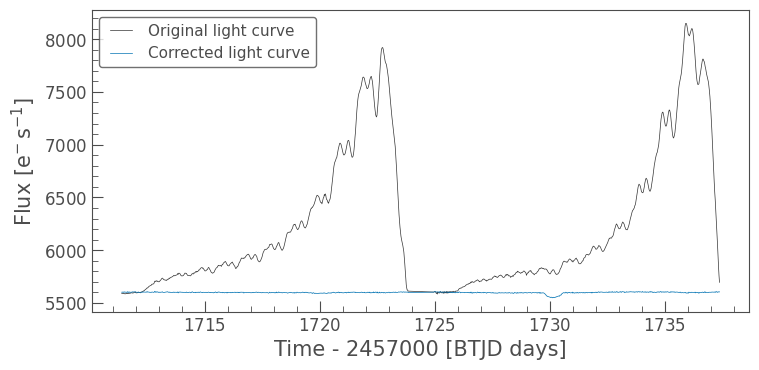

In [31]:
ax = uncorrected_lc.plot(label='Original light curve')
corrected_ffi_lc.plot(ax=ax, label='Corrected light curve');

## 5. Using `RegressionCorrector` on *TESS* Two-Minute Cadence Target Pixel Files

*TESS* releases high-time resolution TPFs of interesting targets. These higher time resolution TPFs have background removed for users by the pipeline. However, there are still common trends in TPF pixels that are not due to scattered light, but could be from, for example, spacecraft motion.

`RegressionCorrector` can be used in exactly the same way to remove these common trends.

In [32]:
# Download a 2-minute cadence Target Pixel File (TPF)
tpf_2min = lk.search_targetpixelfile(target, author='SPOC', cadence=120, sector=15).download()

In [33]:
tpf_2min

TessTargetPixelFile(TICID: 185336364)

Note, unlike the FFI data, the TPF has been processed by the SPOC pipeline, and includes an aperture mask.

In [34]:
# Use the pipeline aperture and an uncorrected light curve
aper = tpf_2min.pipeline_mask
uncorrected_lc = tpf_2min.to_lightcurve()

# Make a design matrix
dm = DesignMatrix(tpf_2min.flux[:, ~aper], name='pixels').pca(5).append_constant()

# Regression Corrector Object
reg = RegressionCorrector(uncorrected_lc)
corrected_lc = reg.correct(dm)

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

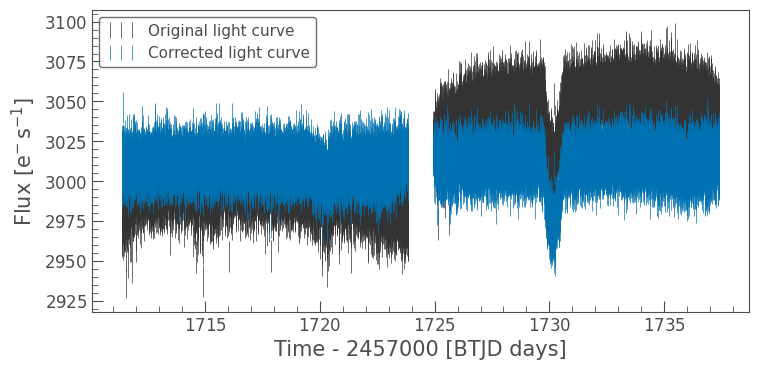

In [35]:
ax = uncorrected_lc.errorbar(label='Original light curve')
corrected_lc.errorbar(ax=ax, label='Corrected light curve');

As you can see, the corrected light curve has removed long-term trends and some motion noise, for example, see time around 1720 Barycentric *TESS* Julian Date (BTJD). We can use the same `diagnose()` method to understand the model that has been fit and subtracted by `RegressionCorrector`.

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

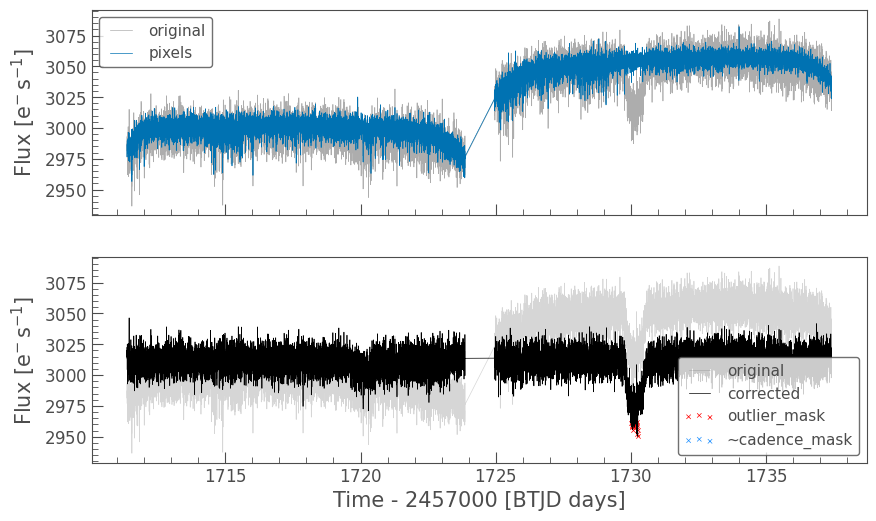

In [36]:
reg.diagnose();

To show the corrected version has improved, we can use the Combined Differential Photometric Precision (CDPP) metric. As shown below, the corrected light curve has a lower CDPP, showing it is less noisy.

In [37]:
uncorrected_lc.estimate_cdpp()

<Quantity 880.81384845 ppm>

In [38]:
corrected_lc.estimate_cdpp()

<Quantity 825.56362758 ppm>

## 6. Should I use `RegressionCorrector` or `PLDCorrector`?

In addition to the corrector demonstrated in this tutorial, Lightkurve has a special case of `RegressionCorrector` called `PLDCorrector`. PLD, or Pixel Level Decorrelation, is a method of removing systematic noise from light curves using linear regression, with a design matrix constructed from a combination of pixel-level light curves. 

For more information about the `PLDCorrector`, please see the tutorial specifically on removing instrumental noise from *K2* and *TESS* light curves using PLD.

For *TESS*, the `PLDCorrector` works in a very similar way to the `RegressionCorrector`. The major difference between them is that `PLDCorrector` constructs its own design matrix, making it a streamlined, versatile tool to apply to any *TESS* or *K2* light curve.

Here, we perform PLD and diagnose the correction in just three lines. To make a more direct comparison to the `RegressionCorrector`, we pass in arguments to set the number of components to five (as in section 2), as well as remove the spline fit.

array([<AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>,
       <AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>],
      dtype=object)

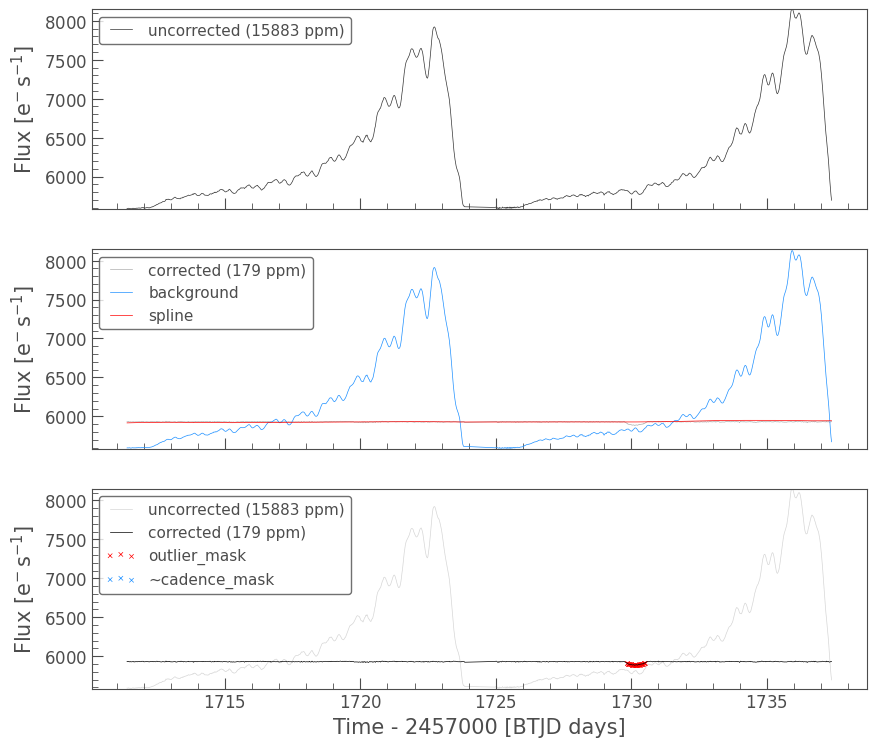

In [39]:
from lightkurve.correctors import PLDCorrector

pld = PLDCorrector(tpf)
pld_corrected_lc = pld.correct(restore_trend=False, pca_components=5)
pld.diagnose();

And there we go!

Now let's compare the performance of these two corrections.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Normalized Flux'>

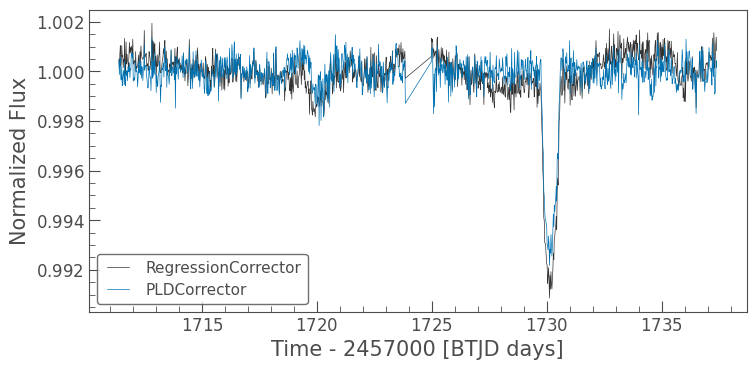

In [40]:
ax = corrected_ffi_lc.normalize().plot(label='RegressionCorrector')
pld_corrected_lc.normalize().plot(label='PLDCorrector', ax=ax);

`PLDCorrector` offers an additional diagnostic plot, named `diagnose_masks`. This allows you to inspect the pixels that were used to create your design matrix.

array([<AxesSubplot:title={'center':'aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'pld_aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>,
       <AxesSubplot:title={'center':'background_aperture_mask'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>],
      dtype=object)

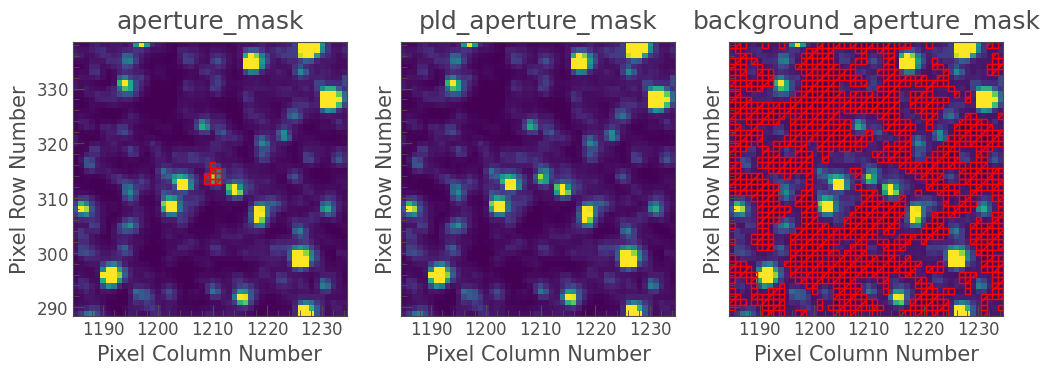

In [41]:
pld.diagnose_masks();

While it is more convenient to apply to light curves and generally works well with default parameters, the `PLDCorrector` is less flexible than the `RegressionCorrector`, which allows you to create your own custom design matrix. However, the `PLDCorrector` also allows you to create "higher order" PLD regressors by taking the products of existing pixel regressors, which improves the performance of corrections to *K2* data (see the paper by [Luger et al. 2016](https://arxiv.org/abs/1607.00524) for more information).

When considering which corrector to use, remember that `PLDCorrector` is minimal and designed to be effective at removing both background scattered light from *TESS* and motion noise from *K2*, while `RegressionCorrector` is flexible and gives you more control over the creation of the design matrix and the correction.

## About this Notebook

**Authors:** Christina Hedges (christinalouisehedges@gmail.com), Nicholas Saunders (nksaun@hawaii.edu), Geert Barentsen

**Updated On:** 2020-09-28

## Citing Lightkurve and its Dependencies

If you use `lightkurve` or its dependencies for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [42]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>